In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import copy
from PIL import Image, ImageFilter
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create a smaller subset of data for quicker experiments
TRAIN_SUBSET_SIZE = 8000  # Reduced from 10000
VALID_SUBSET_SIZE = 8000
TEST_SUBSET_SIZE = 8000


In [2]:

# Set random seeds for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Function for checking device
def get_device():
    if torch.backends.mps.is_available():
        try:
            # Try creating a tensor on MPS
            test_tensor = torch.zeros(1, device="mps")
            print(f"Test tensor created on MPS successfully: {test_tensor.device}")
            print("MPS is working properly")
            return torch.device("mps")
        except Exception as e:
            print(f"Error initializing MPS: {e}")
    
    print("Using CPU")
    return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")


Test tensor created on MPS successfully: mps:0
MPS is working properly
Using device: mps


In [4]:
# Create dataset subset function
def create_subset_dataset(original_dataset, num_samples=10000, balanced=True):
    """
    Create a subset of the original dataset with equal class distribution
    """
    if balanced:
        # Get class labels
        targets = torch.tensor([target for _, target in original_dataset.samples])
        classes = torch.unique(targets)
        num_classes = len(classes)
        samples_per_class = num_samples // num_classes
        
        indices = []
        for cls in classes:
            cls_indices = torch.where(targets == cls)[0]
            # If we have fewer samples than requested, take all of them
            if len(cls_indices) <= samples_per_class:
                indices.extend(cls_indices.tolist())
            else:
                # Otherwise randomly sample
                selected = cls_indices[torch.randperm(len(cls_indices))[:samples_per_class]]
                indices.extend(selected.tolist())
        
        return Subset(original_dataset, indices)
    else:
        # Simple random subset
        return Subset(original_dataset, torch.randperm(len(original_dataset))[:num_samples].tolist())

In [5]:
# Define different data augmentation techniques
def cutout_transform(img, n_holes=1, length=16):
    """Apply cutout augmentation to a tensor image"""
    h = img.size(1)
    w = img.size(2)
    
    mask = torch.ones((h, w))
    
    for n in range(n_holes):
        y = np.random.randint(h)
        x = np.random.randint(w)
        
        y1 = np.clip(y - length // 2, 0, h)
        y2 = np.clip(y + length // 2, 0, h)
        x1 = np.clip(x - length // 2, 0, w)
        x2 = np.clip(x + length // 2, 0, w)
        
        mask[y1: y2, x1: x2] = 0.
    
    mask = mask.expand_as(img)
    return img * mask

class CutoutTransform:
    """Wrapper class for the cutout transform to use in torchvision transforms"""
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length
    
    def __call__(self, img):
        return cutout_transform(img, self.n_holes, self.length)

In [6]:
# Create dictionaries of transforms for our experiments
standard_transforms = {
    'baseline': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    
    'horizontal_flip': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    
    'rotation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    
    'color_jitter': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    
    'combined_standard': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Advanced augmentation with Cutout
advanced_transforms = {
    'cutout': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        CutoutTransform(n_holes=1, length=32)
    ])
}

In [7]:
# Load full datasets first
print("Loading original datasets...")
full_train_dataset = ImageFolder(root='data/train', transform=standard_transforms['baseline'])
full_valid_dataset = ImageFolder(root='data/valid', transform=standard_transforms['baseline'])
full_test_dataset = ImageFolder(root='data/test', transform=standard_transforms['baseline'])

# Create reduced subsets
print("Creating subsets...")
train_dataset = create_subset_dataset(full_train_dataset, num_samples=TRAIN_SUBSET_SIZE)
valid_dataset = create_subset_dataset(full_valid_dataset, num_samples=VALID_SUBSET_SIZE)
test_dataset = create_subset_dataset(full_test_dataset, num_samples=TEST_SUBSET_SIZE)

# Save class names
class_names = full_train_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Loading original datasets...
Creating subsets...
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training samples: 8000
Validation samples: 8000
Test samples: 8000


In [8]:
def create_efficientnet_model(num_classes=10, pretrained=True, dropout_rate=0.2):
    """Create EfficientNet B0 model"""
    if pretrained:
        weights = EfficientNet_B0_Weights.DEFAULT
        model = efficientnet_b0(weights=weights)
    else:
        model = efficientnet_b0(weights=None)
    
    # Replace classifier
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate, inplace=True),
        nn.Linear(in_features=in_features, out_features=num_classes),
    )
    
    return model

In [9]:
# Define custom CNN as a third architecture option
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        # Convolutional blocks
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        
        # Flatten
        x = x.view(-1, 128 * 4 * 4)
        
        # Fully connected
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [10]:
# Training and validation functions
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False) as t:
        for images, labels in t:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            t.set_postfix(loss=loss.item(), acc=100.*correct/total)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

In [11]:
def validate(model, valid_loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(valid_loader.dataset)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

In [12]:
def evaluate(model, test_loader, device):
    """Evaluate model on test set"""
    model.eval()
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels

In [13]:
# Function to conduct an experiment
def run_experiment(experiment_name, model, train_dataset, valid_dataset, test_dataset, 
                  hyperparams, batch_size=64, num_epochs=10):
    """
    Run a full training experiment with given hyperparameters
    """
    print(f"\n{'='*20} Running experiment: {experiment_name} {'='*20}")
    for key, value in hyperparams.items():
        print(f"{key}: {value}")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    # Initialize optimizer
    if hyperparams['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=hyperparams['learning_rate'], 
                              weight_decay=hyperparams['weight_decay'])
    elif hyperparams['optimizer'] == 'sgd':
        momentum = hyperparams.get('momentum', 0.9)  # Default momentum to 0.9 if not specified
        nesterov = hyperparams.get('nesterov', False)  # Default nesterov to False if not specified
        optimizer = optim.SGD(model.parameters(), lr=hyperparams['learning_rate'], 
                             momentum=momentum, weight_decay=hyperparams['weight_decay'],
                             nesterov=nesterov)

    # Initialize criterion
    criterion = nn.CrossEntropyLoss()
    
    # Initialize scheduler
    if hyperparams['scheduler'] == 'plateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    elif hyperparams['scheduler'] == 'cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Lists to store metrics
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    # Training loop
    start_time = time.time()
    best_val_acc = 0
    best_model_wts = None
    
    for epoch in range(num_epochs):
        # Train and validate
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
        valid_loss, valid_acc = validate(model, valid_loader, criterion, device)
        
        # Scheduler step
        if hyperparams['scheduler'] == 'plateau':
            scheduler.step(valid_loss)
        else:
            scheduler.step()
        
        # Store metrics
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)
        
        # Print statistics
        print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.2f}%")
        
        # Save best model
        if valid_acc > best_val_acc:
            best_val_acc = valid_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    
    total_time = time.time() - start_time
    print(f"Training completed in {total_time/60:.2f} minutes")
    
    # Load best model
    model.load_state_dict(best_model_wts)
    
    # Evaluate on test set
    test_acc, all_preds, all_labels = evaluate(model, test_loader, device)
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Return results
    results = {
        'name': experiment_name,
        'hyperparams': hyperparams,
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'train_accuracies': train_accuracies,
        'valid_accuracies': valid_accuracies,
        'test_accuracy': test_acc,
        'confusion_matrix': cm,
        'model_state': best_model_wts,
        'all_preds': all_preds,
        'all_labels': all_labels
    }
    
    return results

In [14]:
# ======= Few-shot learning implementation =======
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone
    
    def forward(self, support_images, support_labels, query_images):
        """
        Implements the forward pass of Prototypical Networks
        
        Args:
            support_images: support set images [n_classes * n_shots, channels, height, width]
            support_labels: support set labels [n_classes * n_shots]
            query_images: query set images [n_queries, channels, height, width]
        
        Returns:
            query_logits: classification logits for the query images
        """
        # Extract features
        support_features = self.backbone(support_images)  # [n_classes * n_shots, feature_dim]
        query_features = self.backbone(query_images)      # [n_queries, feature_dim]
        
        # Compute class prototypes
        n_classes = len(torch.unique(support_labels))
        prototypes = torch.zeros(n_classes, support_features.shape[1], device=support_features.device)
        
        for c in range(n_classes):
            # Select features of class c
            class_mask = (support_labels == c)
            class_features = support_features[class_mask]
            # Average features to get the prototype
            prototypes[c] = class_features.mean(dim=0)
        
        # Compute distances between query features and prototypes
        # Expand dimensions for broadcasting
        query_features = query_features.unsqueeze(1)  # [n_queries, 1, feature_dim]
        prototypes = prototypes.unsqueeze(0)          # [1, n_classes, feature_dim]
        
        # Compute Euclidean distances
        distances = torch.sum((query_features - prototypes)**2, dim=2)
        
        # Convert distances to logits (negative distances)
        return -distances

In [15]:
def few_shot_evaluation(backbone, test_dataset, device, n_way=5, n_shot=5, n_query=15, n_episodes=100):
    """
    Evaluates the backbone on few-shot classification tasks
    """
    backbone.eval()
    
    # Function to create few-shot tasks
    def create_episode(dataset, n_way, n_shot, n_query):
        # Sample n_way classes
        classes = random.sample(range(len(dataset.classes)), n_way)
        
        # Initialize tensors to store images and labels
        support_images = []
        support_labels = []
        query_images = []
        query_labels = []
        
        # For each class, sample n_shot and n_query examples
        for i, cls in enumerate(classes):
            # Get indices of all examples from this class
            class_indices = [idx for idx, (_, label) in enumerate(dataset) if label == cls]
            # Sample support and query sets
            support_indices = random.sample(class_indices, n_shot)
            remaining_indices = [idx for idx in class_indices if idx not in support_indices]
            query_indices = random.sample(remaining_indices, min(n_query, len(remaining_indices)))
            
            # Add to support and query sets
            for idx in support_indices:
                image, _ = dataset[idx]
                support_images.append(image)
                support_labels.append(i)  # Use an index from 0 to n_way-1 as the label
            
            for idx in query_indices:
                image, _ = dataset[idx]
                query_images.append(image)
                query_labels.append(i)
        
        # Convert to tensors
        support_images = torch.stack(support_images)
        support_labels = torch.tensor(support_labels)
        query_images = torch.stack(query_images)
        query_labels = torch.tensor(query_labels)
        
        return support_images, support_labels, query_images, query_labels
    
    # Create prototypical network
    proto_net = PrototypicalNetworks(backbone).to(device)
    
    # List to store accuracies
    accuracies = []
    
    # Evaluate over multiple episodes
    for episode in tqdm(range(n_episodes), desc="Few-shot evaluation"):
        # Create an episode (task)
        support_images, support_labels, query_images, query_labels = create_episode(
            test_dataset, n_way, n_shot, n_query
        )
        
        # Move to device
        support_images = support_images.to(device)
        support_labels = support_labels.to(device)
        query_images = query_images.to(device)
        query_labels = query_labels.to(device)
        
        # Forward pass
        with torch.no_grad():
            query_logits = proto_net(support_images, support_labels, query_images)
            _, query_preds = torch.max(query_logits, dim=1)
            
            # Calculate accuracy
            accuracy = (query_preds == query_labels).float().mean().item() * 100
            accuracies.append(accuracy)
    
    # Return average accuracy
    avg_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    
    print(f"Few-shot learning ({n_way}-way, {n_shot}-shot): {avg_accuracy:.2f}% ± {std_accuracy:.2f}%")
    
    return avg_accuracy, std_accuracy

In [16]:
# Define feature extractor for few-shot learning
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        # Use a pre-trained model but remove the final layer
        self.model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        # Remove the classifier
        self.features = nn.Sequential(*list(self.model.children())[:-1])
        # Add a flatten layer
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        return x

In [17]:
# Function to implement ensemble prediction
def ensemble_prediction(models, test_loader, device, method='hard'):
    """
    Implement ensemble prediction using multiple models
    
    Args:
        models: List of trained models
        test_loader: DataLoader for test data
        device: Device to run on
        method: 'hard' for majority voting or 'soft' for probability averaging
    
    Returns:
        accuracy: Ensemble accuracy
    """
    
    if not models:
        return 0.0, [], []
    
    all_predictions = []
    all_probs = []
    
    # Get predictions from each model
    for model in models:
        model.eval()
        predictions = []
        probabilities = []
        
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
                probabilities.append(probs.cpu())
        
        all_predictions.append(predictions)
        all_probs.append(torch.cat(probabilities, dim=0).numpy())
    
    # Get true labels
    true_labels = []
    for _, labels in test_loader:
        true_labels.extend(labels.numpy())
    
    # Create ensemble predictions
    if method == 'hard':
        # Majority voting
        ensemble_preds = []
        for i in range(len(true_labels)):
            votes = [all_predictions[j][i] for j in range(len(models))]
            # Count occurrences of each class
            vote_counts = np.bincount(votes, minlength=num_classes)
            # Select class with most votes
            ensemble_preds.append(np.argmax(vote_counts))
    else:  # 'soft' voting
        # Average probabilities
        ensemble_probs = np.mean(all_probs, axis=0)
        ensemble_preds = np.argmax(ensemble_probs, axis=1)
    
    # Calculate accuracy
    accuracy = np.mean(np.array(ensemble_preds) == np.array(true_labels)) * 100
    
    return accuracy, ensemble_preds, true_labels

In [18]:
# EXPERIMENT CONFIGURATIONS
# 1. Architecture Comparison (removed ResNet)
architectures = {
    'efficientnet': create_efficientnet_model(num_classes),
    'custom_cnn': CustomCNN(num_classes)
}

# 2. Hyperparameter Configurations for Training Process
training_hyperparams = [
    {'optimizer': 'adam', 'learning_rate': 0.001, 'scheduler': 'plateau', 'weight_decay': 0.0001},
    {'optimizer': 'sgd', 'learning_rate': 0.01, 'scheduler': 'plateau', 'weight_decay': 0.0001},
    {'optimizer': 'adam', 'learning_rate': 0.001, 'scheduler': 'cosine', 'weight_decay': 0.0001},
    {'optimizer': 'adam', 'learning_rate': 0.0001, 'scheduler': 'plateau', 'weight_decay': 0.0001},  # Lower learning rate
    {'optimizer': 'adam', 'learning_rate': 0.01, 'scheduler': 'plateau', 'weight_decay': 0.0001},    # Higher learning rate
    {'optimizer': 'sgd', 'learning_rate': 0.001, 'scheduler': 'cosine', 'weight_decay': 0.0001},     # SGD with cosine scheduler
    {'optimizer': 'sgd', 'learning_rate': 0.01, 'scheduler': 'cosine', 'weight_decay': 0.0001, 'momentum': 0.9, 'nesterov': True}  # SGD with Nesterov momentum
]

# 3. Hyperparameter Configurations for Regularization
regularization_hyperparams = [
    {'optimizer': 'adam', 'learning_rate': 0.001, 'scheduler': 'plateau', 'weight_decay': 0.0001, 'dropout_rate': 0.2},
    {'optimizer': 'adam', 'learning_rate': 0.001, 'scheduler': 'plateau', 'weight_decay': 0.001, 'dropout_rate': 0.2},
    {'optimizer': 'adam', 'learning_rate': 0.001, 'scheduler': 'plateau', 'weight_decay': 0.0, 'dropout_rate': 0.2},
    {'optimizer': 'adam', 'learning_rate': 0.001, 'scheduler': 'plateau', 'weight_decay': 0.0001, 'dropout_rate': 0.5},
    {'optimizer': 'adam', 'learning_rate': 0.001, 'scheduler': 'plateau', 'weight_decay': 0.0001, 'dropout_rate': 0.0}
]

# 4. Data Augmentation Experiments
# We'll use a modified version of the train_dataset for each transform
augmentation_datasets = {}

# Apply each transform to create new datasets
for name, transform in standard_transforms.items():
    augmentation_datasets[name] = ImageFolder(
        root='data/train', 
        transform=transform
    )
    # Create a subset of the data
    augmentation_datasets[name] = create_subset_dataset(augmentation_datasets[name], num_samples=TRAIN_SUBSET_SIZE)

# Add advanced augmentation
for name, transform in advanced_transforms.items():
    augmentation_datasets[name] = ImageFolder(
        root='data/train', 
        transform=transform
    )
    # Create a subset of the data
    augmentation_datasets[name] = create_subset_dataset(augmentation_datasets[name], num_samples=TRAIN_SUBSET_SIZE)

# Dictionary to store results of all experiments
all_results = {}

In [ ]:
# ==== RUN EXPERIMENTS ====
# 1. Architecture Comparison
print("\n" + "="*30 + " ARCHITECTURE COMPARISON " + "="*30)
architecture_results = {}

for arch_name, model in architectures.items():
    print(f"\nTraining {arch_name}...")
    model = model.to(device)
    
    hyperparams = {
        'optimizer': 'adam',
        'learning_rate': 0.001,
        'scheduler': 'plateau',
        'weight_decay': 0.0001
    }
    
    results = run_experiment(
        f"Architecture_{arch_name}",
        model, 
        train_dataset, 
        valid_dataset, 
        test_dataset,
        hyperparams,
        batch_size=128,  # Larger batch size for faster training
        num_epochs=3  # Further reduced epochs for faster comparison
    )
    
    architecture_results[arch_name] = results
    all_results[f"Architecture_{arch_name}"] = results
    
    # Save model state
    torch.save(model.state_dict(), f"{arch_name}_model.pth")


============================== ARCHITECTURE COMPARISON ==============================

Training efficientnet...

==================== Running experiment: Architecture_efficientnet ====================
optimizer: adam
learning_rate: 0.001
scheduler: plateau
weight_decay: 0.0001


Epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/3 | LR: 0.001000
Train Loss: 0.9279 | Train Acc: 68.56%
Valid Loss: 0.6850 | Valid Acc: 76.35%


Epoch 2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/3 | LR: 0.001000
Train Loss: 0.4403 | Train Acc: 84.61%
Valid Loss: 0.7002 | Valid Acc: 76.81%


Epoch 3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/3 | LR: 0.001000
Train Loss: 0.3044 | Train Acc: 89.42%
Valid Loss: 0.7406 | Valid Acc: 77.71%
Training completed in 2.85 minutes
Test Accuracy: 78.67%

Training custom_cnn...

==================== Running experiment: Architecture_custom_cnn ====================
optimizer: adam
learning_rate: 0.001
scheduler: plateau
weight_decay: 0.0001


Epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/3 | LR: 0.001000
Train Loss: 2.1121 | Train Acc: 20.19%
Valid Loss: 2.1781 | Valid Acc: 19.24%


Epoch 2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/3 | LR: 0.001000
Train Loss: 1.9828 | Train Acc: 23.55%
Valid Loss: 1.9764 | Valid Acc: 24.98%


Epoch 3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/3 | LR: 0.001000
Train Loss: 1.9205 | Train Acc: 26.07%
Valid Loss: 1.8664 | Valid Acc: 28.95%
Training completed in 3.15 minutes
Test Accuracy: 28.48%


In [20]:
# 2. Training Hyperparameters Comparison
print("\n" + "="*30 + " TRAINING HYPERPARAMETERS COMPARISON " + "="*30)
training_results = {}

for arch_name, model_creator in architectures.items():
    print(f"\nTesting architecture: {arch_name}")
    
    for i, hyperparams in enumerate(training_hyperparams):
        # Create a new model with this architecture
        if arch_name == 'efficientnet':
            model = create_efficientnet_model(num_classes)
        else:
            model = CustomCNN(num_classes)
        
        model = model.to(device)
        
        experiment_name = f"Training_Hyperparams_{arch_name}_{i+1}"
        results = run_experiment(
            experiment_name,
            model, 
            train_dataset, 
            valid_dataset, 
            test_dataset,
            hyperparams,
            batch_size=128,
            num_epochs=3
        )
        
        training_results[experiment_name] = results
        all_results[experiment_name] = results


============================== TRAINING HYPERPARAMETERS COMPARISON ==============================
Using best architecture: efficientnet

==================== Running experiment: Training_Hyperparams_1 ====================
optimizer: adam
learning_rate: 0.001
scheduler: plateau
weight_decay: 0.0001


Epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/3 | LR: 0.001000
Train Loss: 0.2789 | Train Acc: 90.33%
Valid Loss: 0.7669 | Valid Acc: 77.76%


Epoch 2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/3 | LR: 0.001000
Train Loss: 0.1761 | Train Acc: 94.04%
Valid Loss: 0.8718 | Valid Acc: 77.96%


Epoch 3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/3 | LR: 0.001000
Train Loss: 0.1405 | Train Acc: 95.34%
Valid Loss: 1.0005 | Valid Acc: 76.54%
Training completed in 2.89 minutes
Test Accuracy: 77.96%

==================== Running experiment: Training_Hyperparams_2 ====================
optimizer: sgd
learning_rate: 0.01
scheduler: plateau
weight_decay: 0.0001


Epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/3 | LR: 0.010000
Train Loss: 0.0840 | Train Acc: 97.38%
Valid Loss: 0.7036 | Valid Acc: 81.00%


Epoch 2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/3 | LR: 0.010000
Train Loss: 0.0436 | Train Acc: 98.76%
Valid Loss: 0.7085 | Valid Acc: 81.81%


Epoch 3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/3 | LR: 0.010000
Train Loss: 0.0280 | Train Acc: 99.21%
Valid Loss: 0.7164 | Valid Acc: 82.04%
Training completed in 2.92 minutes
Test Accuracy: 81.65%

==================== Running experiment: Training_Hyperparams_3 ====================
optimizer: adam
learning_rate: 0.001
scheduler: cosine
weight_decay: 0.0001


Epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/3 | LR: 0.000750
Train Loss: 0.1856 | Train Acc: 93.92%
Valid Loss: 0.8499 | Valid Acc: 77.79%


Epoch 2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/3 | LR: 0.000250
Train Loss: 0.0929 | Train Acc: 97.03%
Valid Loss: 0.8195 | Valid Acc: 80.06%


Epoch 3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/3 | LR: 0.000000
Train Loss: 0.0386 | Train Acc: 98.89%
Valid Loss: 0.7621 | Valid Acc: 81.89%
Training completed in 2.98 minutes
Test Accuracy: 81.79%


In [21]:
# 3. Regularization Hyperparameters Comparison
print("\n" + "="*30 + " REGULARIZATION HYPERPARAMETERS COMPARISON " + "="*30)
regularization_results = {}

for arch_name, model_creator in architectures.items():
    print(f"\nTesting architecture: {arch_name}")
    
    for i, hyperparams in enumerate(regularization_hyperparams):
        # Create a new model with this architecture
        if arch_name == 'efficientnet':
            model = create_efficientnet_model(num_classes, dropout_rate=hyperparams.get('dropout_rate', 0.2))
        else:
            model = CustomCNN(num_classes)  # Note: You'd need to modify CustomCNN to use the dropout rate parameter
        
        model = model.to(device)
        
        experiment_name = f"Regularization_Hyperparams_{arch_name}_{i+1}"
        results = run_experiment(
            experiment_name,
            model, 
            train_dataset, 
            valid_dataset, 
            test_dataset,
            hyperparams,
            batch_size=128,
            num_epochs=3
        )
        
        regularization_results[experiment_name] = results
        all_results[experiment_name] = results


============================== REGULARIZATION HYPERPARAMETERS COMPARISON ==============================

==================== Running experiment: Regularization_Hyperparams_1 ====================
optimizer: adam
learning_rate: 0.001
scheduler: plateau
weight_decay: 0.0001


Epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/3 | LR: 0.001000
Train Loss: 0.1531 | Train Acc: 94.95%
Valid Loss: 1.0889 | Valid Acc: 74.97%


Epoch 2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/3 | LR: 0.001000
Train Loss: 0.1227 | Train Acc: 96.25%
Valid Loss: 0.9122 | Valid Acc: 77.61%


Epoch 3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/3 | LR: 0.001000
Train Loss: 0.1048 | Train Acc: 96.55%
Valid Loss: 1.0311 | Valid Acc: 77.34%
Training completed in 2.99 minutes
Test Accuracy: 78.15%

==================== Running experiment: Regularization_Hyperparams_2 ====================
optimizer: adam
learning_rate: 0.001
scheduler: plateau
weight_decay: 0.001


Epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/3 | LR: 0.001000
Train Loss: 0.1576 | Train Acc: 94.89%
Valid Loss: 0.9251 | Valid Acc: 75.76%


Epoch 2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/3 | LR: 0.001000
Train Loss: 0.1568 | Train Acc: 94.70%
Valid Loss: 0.8873 | Valid Acc: 76.86%


Epoch 3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/3 | LR: 0.001000
Train Loss: 0.1501 | Train Acc: 95.04%
Valid Loss: 0.8594 | Valid Acc: 76.59%
Training completed in 2.98 minutes
Test Accuracy: 76.45%

==================== Running experiment: Regularization_Hyperparams_3 ====================
optimizer: adam
learning_rate: 0.001
scheduler: plateau
weight_decay: 0.0


Epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/3 | LR: 0.001000
Train Loss: 0.1663 | Train Acc: 94.50%
Valid Loss: 1.0589 | Valid Acc: 76.99%


Epoch 2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/3 | LR: 0.001000
Train Loss: 0.1346 | Train Acc: 95.55%
Valid Loss: 0.9799 | Valid Acc: 76.03%


Epoch 3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/3 | LR: 0.001000
Train Loss: 0.0913 | Train Acc: 96.85%
Valid Loss: 1.1091 | Valid Acc: 76.74%
Training completed in 2.97 minutes
Test Accuracy: 76.17%


In [22]:
# 4. Data Augmentation Experiments
print("\n" + "="*30 + " DATA AUGMENTATION COMPARISON " + "="*30)
augmentation_results = {}

for arch_name, model_creator in architectures.items():
    print(f"\nTesting architecture: {arch_name}")
    
    # Standard augmentations
    for aug_name in ['baseline', 'horizontal_flip', 'rotation', 'color_jitter']:
        print(f"\nTesting standard augmentation: {aug_name}")
        
        # Create a new model with this architecture
        if arch_name == 'efficientnet':
            model = create_efficientnet_model(num_classes)
        else:
            model = CustomCNN(num_classes)
            
        model = model.to(device)
        
        experiment_name = f"Augmentation_{arch_name}_{aug_name}"
        results = run_experiment(
            experiment_name,
            model,
            augmentation_datasets[aug_name],
            valid_dataset,
            test_dataset,
            hyperparams,
            batch_size=128,
            num_epochs=3
        )
        
        augmentation_results[experiment_name] = results
        all_results[experiment_name] = results
    
    # Advanced augmentation (cutout)
    print(f"\nTesting advanced augmentation with {arch_name}: cutout")
    
    # Create a new model with this architecture
    if arch_name == 'efficientnet':
        model = create_efficientnet_model(num_classes)
    else:
        model = CustomCNN(num_classes)
        
    model = model.to(device)
    
    experiment_name = f"Augmentation_{arch_name}_cutout"
    results = run_experiment(
        experiment_name,
        model,
        augmentation_datasets['cutout'],
        valid_dataset,
        test_dataset,
        hyperparams,
        batch_size=128,
        num_epochs=3
    )
    
    augmentation_results[experiment_name] = results
    all_results[experiment_name] = results


============================== DATA AUGMENTATION COMPARISON ==============================

Testing standard augmentation: baseline

==================== Running experiment: Augmentation_baseline ====================
optimizer: adam
learning_rate: 0.001
scheduler: plateau
weight_decay: 0.0001


Epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/3 | LR: 0.001000
Train Loss: 0.6552 | Train Acc: 78.70%
Valid Loss: 0.5431 | Valid Acc: 80.50%


Epoch 2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/3 | LR: 0.001000
Train Loss: 0.3117 | Train Acc: 89.36%
Valid Loss: 0.6553 | Valid Acc: 79.49%


Epoch 3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/3 | LR: 0.001000
Train Loss: 0.2018 | Train Acc: 93.17%
Valid Loss: 0.8108 | Valid Acc: 77.61%
Training completed in 3.02 minutes
Test Accuracy: 79.96%

Testing standard augmentation: horizontal_flip

==================== Running experiment: Augmentation_horizontal_flip ====================
optimizer: adam
learning_rate: 0.001
scheduler: plateau
weight_decay: 0.0001


Epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/3 | LR: 0.001000
Train Loss: 0.6042 | Train Acc: 78.84%
Valid Loss: 0.5905 | Valid Acc: 79.25%


Epoch 2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/3 | LR: 0.001000
Train Loss: 0.3724 | Train Acc: 86.59%
Valid Loss: 0.6182 | Valid Acc: 79.61%


Epoch 3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/3 | LR: 0.001000
Train Loss: 0.2613 | Train Acc: 90.70%
Valid Loss: 0.6715 | Valid Acc: 79.09%
Training completed in 3.05 minutes
Test Accuracy: 79.60%

Testing standard augmentation: rotation

==================== Running experiment: Augmentation_rotation ====================
optimizer: adam
learning_rate: 0.001
scheduler: plateau
weight_decay: 0.0001


Epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/3 | LR: 0.001000
Train Loss: 0.6220 | Train Acc: 78.31%
Valid Loss: 0.5323 | Valid Acc: 81.51%


Epoch 2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/3 | LR: 0.001000
Train Loss: 0.3810 | Train Acc: 86.54%
Valid Loss: 0.6145 | Valid Acc: 80.00%


Epoch 3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/3 | LR: 0.001000
Train Loss: 0.3094 | Train Acc: 88.91%
Valid Loss: 0.6353 | Valid Acc: 79.58%
Training completed in 3.34 minutes
Test Accuracy: 81.10%

Testing standard augmentation: color_jitter

==================== Running experiment: Augmentation_color_jitter ====================
optimizer: adam
learning_rate: 0.001
scheduler: plateau
weight_decay: 0.0001


Epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/3 | LR: 0.001000
Train Loss: 0.5990 | Train Acc: 78.89%
Valid Loss: 0.5583 | Valid Acc: 80.11%


Epoch 2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/3 | LR: 0.001000
Train Loss: 0.3578 | Train Acc: 87.67%
Valid Loss: 0.6170 | Valid Acc: 79.45%


Epoch 3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/3 | LR: 0.001000
Train Loss: 0.2520 | Train Acc: 91.08%
Valid Loss: 0.6793 | Valid Acc: 78.71%
Training completed in 3.69 minutes
Test Accuracy: 80.74%


In [ ]:
# 5. Few-shot Learning Experiment
print("\n" + "="*30 + " FEW-SHOT LEARNING " + "="*30)

# Create feature extractors for few-shot learning
feature_extractor = FeatureExtractor().to(device)

# Create custom CNN feature extractor
class CustomCNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CustomCNNFeatureExtractor, self).__init__()
        # Create the base components of CustomCNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.relu4 = nn.ReLU()
    
    def forward(self, x):
        # Apply convolution blocks
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        
        # Flatten and apply FC layer
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        
        return x

custom_feature_extractor = CustomCNNFeatureExtractor().to(device)

# Modify few_shot_evaluation to handle Subset objects
def few_shot_evaluation(backbone, dataset, device, n_way=5, n_shot=5, n_query=15, n_episodes=100):
    """
    Evaluates the backbone on few-shot classification tasks
    """
    backbone.eval()
    
    # Get the original dataset if this is a subset
    original_dataset = dataset
    if isinstance(dataset, Subset):
        # Get the original dataset
        original_dataset = dataset.dataset
        # Get the class mapping from the original dataset
        class_indices = {}
        for idx in dataset.indices:
            _, label = original_dataset[idx]
            if label not in class_indices:
                class_indices[label] = []
            class_indices[label].append(idx)
    else:
        # If not a subset, create the mapping directly
        class_indices = {}
        for idx, (_, label) in enumerate(dataset):
            if label not in class_indices:
                class_indices[label] = []
            class_indices[label].append(idx)
    
    # Create few-shot tasks function
    def create_episode(n_way, n_shot, n_query):
        # Sample n_way classes
        available_classes = list(class_indices.keys())
        if len(available_classes) < n_way:
            print(f"Warning: Only {len(available_classes)} classes available, but {n_way} requested.")
            n_way = len(available_classes)
        
        classes = random.sample(available_classes, n_way)
        
        # Initialize tensors to store images and labels
        support_images = []
        support_labels = []
        query_images = []
        query_labels = []
        
        # For each class, sample n_shot and n_query examples
        for i, cls in enumerate(classes):
            # Get indices of all examples from this class
            cls_indices = class_indices[cls]
            
            # Sample support and query sets
            if len(cls_indices) <= n_shot:
                support_indices = cls_indices
                query_indices = []
            else:
                # Randomly sample without replacement
                random.shuffle(cls_indices)
                support_indices = cls_indices[:n_shot]
                query_indices = cls_indices[n_shot:n_shot+min(n_query, len(cls_indices)-n_shot)]
            
            # Add to support and query sets
            for idx in support_indices:
                image, _ = original_dataset[idx]
                support_images.append(image)
                support_labels.append(i)  # Use an index from 0 to n_way-1 as the label
            
            for idx in query_indices:
                image, _ = original_dataset[idx]
                query_images.append(image)
                query_labels.append(i)
        
        # Convert to tensors
        support_images = torch.stack(support_images)
        support_labels = torch.tensor(support_labels)
        query_images = torch.stack(query_images)
        query_labels = torch.tensor(query_labels)
        
        return support_images, support_labels, query_images, query_labels
    
    # Create prototypical network
    proto_net = PrototypicalNetworks(backbone).to(device)
    
    # List to store accuracies
    accuracies = []
    
    # Evaluate over multiple episodes
    for episode in tqdm(range(n_episodes), desc="Few-shot evaluation"):
        # Create an episode (task)
        support_images, support_labels, query_images, query_labels = create_episode(
            n_way, n_shot, n_query
        )
        
        # Skip episodes with too few query examples
        if len(query_images) < 5:
            continue
        
        # Move to device
        support_images = support_images.to(device)
        support_labels = support_labels.to(device)
        query_images = query_images.to(device)
        query_labels = query_labels.to(device)
        
        # Forward pass
        with torch.no_grad():
            query_logits = proto_net(support_images, support_labels, query_images)
            _, query_preds = torch.max(query_logits, dim=1)
            
            # Calculate accuracy
            accuracy = (query_preds == query_labels).float().mean().item() * 100
            accuracies.append(accuracy)
    
    # Return average accuracy
    if accuracies:
        avg_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)
    else:
        avg_accuracy = 0
        std_accuracy = 0
    
    print(f"Few-shot learning ({n_way}-way, {n_shot}-shot): {avg_accuracy:.2f}% ± {std_accuracy:.2f}%")
    
    return avg_accuracy, std_accuracy

print("Evaluating few-shot learning capabilities...")

# Evaluate EfficientNet feature extractor
print("\nTesting EfficientNet feature extractor:")
efficientnet_acc, efficientnet_std = few_shot_evaluation(
    feature_extractor, 
    test_dataset, 
    device, 
    n_way=5,    # 5-way classification 
    n_shot=5,   # 5-shot learning
    n_query=15, # 15 query samples per class
    n_episodes=20  # 20 episodes for quick evaluation
)

# Evaluate Custom CNN feature extractor
print("\nTesting Custom CNN feature extractor:")
custom_acc, custom_std = few_shot_evaluation(
    custom_feature_extractor,
    test_dataset,
    device,
    n_way=5,
    n_shot=5,
    n_query=15,
    n_episodes=20
)

# Store results for both architectures
few_shot_results = {
    'efficientnet': {
        'name': 'Few-shot Learning (EfficientNet, 5-way, 5-shot)',
        'accuracy': efficientnet_acc,
        'std': efficientnet_std
    },
    'custom_cnn': {
        'name': 'Few-shot Learning (Custom CNN, 5-way, 5-shot)', 
        'accuracy': custom_acc,
        'std': custom_std
    }
}

# Add results to all_results
all_results['few_shot_efficientnet'] = few_shot_results['efficientnet']
all_results['few_shot_custom_cnn'] = few_shot_results['custom_cnn']

# Print comparison
print("\nFew-shot Learning Architecture Comparison:")
for arch_name, result in few_shot_results.items():
    print(f"{arch_name}: {result['accuracy']:.2f}% ± {result['std']:.2f}%")


============================== FEW-SHOT LEARNING ==============================
Evaluating few-shot learning capabilities...


Few-shot evaluation:   0%|          | 0/20 [00:00<?, ?it/s]

Few-shot learning (5-way, 5-shot): 73.53% ± 8.09%


In [25]:
# 6. Reduced Training Set Size Experiment
print("\n" + "="*30 + " REDUCED TRAINING SET EXPERIMENT " + "="*30)

# Create even smaller training subsets
smaller_train_sizes = [TRAIN_SUBSET_SIZE // 2, TRAIN_SUBSET_SIZE // 4]
reduction_results = {}

for arch_name, model_creator in architectures.items():
    print(f"\nTesting architecture: {arch_name}")
    
    for size in smaller_train_sizes:
        print(f"\nTesting with reduced training set size: {size} samples")
        
        # Create reduced training dataset
        reduced_train_dataset = create_subset_dataset(full_train_dataset, num_samples=size)
        
        # Create a new model with this architecture
        if arch_name == 'efficientnet':
            model = create_efficientnet_model(num_classes)
        else:
            model = CustomCNN(num_classes)
            
        model = model.to(device)
        
        experiment_name = f"Reduced_Train_Size_{arch_name}_{size}"
        results = run_experiment(
            experiment_name,
            model,
            reduced_train_dataset,
            valid_dataset,
            test_dataset,
            hyperparams,
            batch_size=128,
            num_epochs=3
        )
        
        reduction_results[experiment_name] = results
        all_results[experiment_name] = results


============================== REDUCED TRAINING SET EXPERIMENT ==============================

Testing with reduced training set size: 4000 samples

==================== Running experiment: Reduced_Train_Size_4000 ====================
optimizer: adam
learning_rate: 0.001
scheduler: plateau
weight_decay: 0.0001


Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/3 | LR: 0.001000
Train Loss: 0.5410 | Train Acc: 81.50%
Valid Loss: 0.5539 | Valid Acc: 79.96%


Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/3 | LR: 0.001000
Train Loss: 0.2097 | Train Acc: 93.08%
Valid Loss: 0.5776 | Valid Acc: 80.99%


Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/3 | LR: 0.001000
Train Loss: 0.1162 | Train Acc: 96.05%
Valid Loss: 0.6875 | Valid Acc: 80.09%
Training completed in 2.02 minutes
Test Accuracy: 81.66%

Testing with reduced training set size: 2000 samples

==================== Running experiment: Reduced_Train_Size_2000 ====================
optimizer: adam
learning_rate: 0.001
scheduler: plateau
weight_decay: 0.0001


Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/3 | LR: 0.001000
Train Loss: 0.5861 | Train Acc: 79.95%
Valid Loss: 0.6542 | Valid Acc: 78.28%


Epoch 2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/3 | LR: 0.001000
Train Loss: 0.2467 | Train Acc: 92.55%
Valid Loss: 0.5533 | Valid Acc: 81.06%


Epoch 3:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/3 | LR: 0.001000
Train Loss: 0.0887 | Train Acc: 97.60%
Valid Loss: 0.5822 | Valid Acc: 81.41%
Training completed in 1.47 minutes
Test Accuracy: 81.54%


In [26]:
# 7. Ensemble Methods
print("\n" + "="*30 + " ENSEMBLE METHODS " + "="*30)

# Instead of trying to load saved model states which have different architectures,
# let's train a few simple models separately for the ensemble

# Create test data loader for ensemble evaluation
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

# Train 3 different models with slight variations for the ensemble
ensemble_models = []
criterion = nn.CrossEntropyLoss()

# 7. Ensemble Methods
print("\n" + "="*30 + " ENSEMBLE METHODS " + "="*30)
ensemble_results = {}

for arch_name, model_creator in architectures.items():
    print(f"\nTesting ensemble for architecture: {arch_name}")
    
    # Train 3 different models with this architecture
    ensemble_models = []
    
    for i in range(3):
        print(f"\nTraining ensemble model {i+1}/3...")
        
        # Create a new model with this architecture
        if arch_name == 'efficientnet':
            model = create_efficientnet_model(num_classes)
        else:
            model = CustomCNN(num_classes)
            
        model = model.to(device)
        
        # Rest of the training code...
        # [existing ensemble creation code]
        
    # Test ensemble methods
    print(f"Testing ensemble methods for {arch_name}...")
    # Hard voting
    hard_accuracy, hard_preds, hard_labels = ensemble_prediction(
        ensemble_models,
        test_loader,
        device,
        method='hard'
    )
    print(f"Hard voting ensemble accuracy ({arch_name}): {hard_accuracy:.2f}%")
    
    # Soft voting
    soft_accuracy, soft_preds, soft_labels = ensemble_prediction(
        ensemble_models,
        test_loader,
        device,
        method='soft'
    )
    print(f"Soft voting ensemble accuracy ({arch_name}): {soft_accuracy:.2f}%")
    
    ensemble_results[arch_name] = {
        'hard_voting': {
            'accuracy': hard_accuracy,
            'predictions': hard_preds,
            'labels': hard_labels
        },
        'soft_voting': {
            'accuracy': soft_accuracy,
            'predictions': soft_preds,
            'labels': soft_labels
        }
    }
    all_results[f'ensemble_{arch_name}'] = ensemble_results[arch_name]


============================== ENSEMBLE METHODS ==============================

Training ensemble model 1/3...


Epoch 1:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/2 | Train Acc: 88.31% | Valid Acc: 81.15%


Epoch 2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/2 | Train Acc: 96.41% | Valid Acc: 81.06%

Training ensemble model 2/3...


Epoch 1:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/2 | Train Acc: 93.38% | Valid Acc: 77.89%


Epoch 2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/2 | Train Acc: 96.64% | Valid Acc: 79.39%

Training ensemble model 3/3...


Epoch 1:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/2 | Train Acc: 93.34% | Valid Acc: 76.40%


Epoch 2:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/2 | Train Acc: 96.02% | Valid Acc: 77.55%
Testing ensemble methods...
Hard voting ensemble accuracy: 77.60%
Soft voting ensemble accuracy: 77.60%


In [27]:
# 8. Summarize and Visualize Results
print("\n" + "="*30 + " RESULTS SUMMARY " + "="*30)

# 1. Architecture Comparison
print("\nArchitecture Comparison:")
for arch_name, results in architecture_results.items():
    print(f"{arch_name}: {results['test_accuracy']:.2f}%")

# 2. Training Hyperparameters
print("\nTraining Hyperparameters Comparison:")
for name, results in training_results.items():
    # Extract architecture name from the experiment name
    parts = name.split('_')
    if len(parts) > 2:  # If it contains architecture info
        arch = parts[2]  # Architecture name should be the third part
        print(f"{name} ({arch}) - {results['hyperparams']}: {results['test_accuracy']:.2f}%")
    else:
        print(f"{name} - {results['hyperparams']}: {results['test_accuracy']:.2f}%")

# 3. Regularization Hyperparameters
print("\nRegularization Hyperparameters Comparison:")
for name, results in regularization_results.items():
    # Extract architecture name if present
    parts = name.split('_')
    if len(parts) > 2:  # If it contains architecture info
        arch = parts[2]  # Architecture name should be the third part
        print(f"{name} ({arch}) - Weight Decay: {results['hyperparams']['weight_decay']}: {results['test_accuracy']:.2f}%")
    else:
        print(f"{name} - Weight Decay: {results['hyperparams']['weight_decay']}: {results['test_accuracy']:.2f}%")

# 4. Data Augmentation
print("\nData Augmentation Comparison:")
for name, results in augmentation_results.items():
    print(f"{name}: {results['test_accuracy']:.2f}%")

# 5. Few-shot Learning
print("\nFew-shot Learning Comparison:")
for arch_name, result in few_shot_results.items():
    print(f"{arch_name}: {result['accuracy']:.2f}% ± {result['std']:.2f}%")

# 6. Reduced Training Set Size
print("\nReduced Training Set Size Comparison:")
for name, results in reduction_results.items():
    parts = name.split('_')
    if len(parts) > 3:  # If it contains architecture info
        arch = parts[3]  # Architecture name
        size = parts[4]  # Size should be the last part
        print(f"Size {size} ({arch}): {results['test_accuracy']:.2f}%")
    else:
        size = name.split('_')[-1]
        print(f"Size {size}: {results['test_accuracy']:.2f}%")

# 7. Ensemble Methods
print("\nEnsemble Methods Comparison:")
if isinstance(ensemble_results, dict):
    # Check if we have separate results for each architecture
    if 'efficientnet' in ensemble_results or 'custom_cnn' in ensemble_results:
        for arch, results in ensemble_results.items():
            print(f"{arch} - Hard Voting: {results['hard_voting']['accuracy']:.2f}%")
            print(f"{arch} - Soft Voting: {results['soft_voting']['accuracy']:.2f}%")
    else:
        # Original format
        print(f"Hard Voting: {ensemble_results['hard_voting']['accuracy']:.2f}%")
        print(f"Soft Voting: {ensemble_results['soft_voting']['accuracy']:.2f}%")


============================== RESULTS SUMMARY ==============================

Architecture Comparison:
efficientnet: 78.67%
custom_cnn: 28.48%

Training Hyperparameters Comparison:
Training_Hyperparams_1 - {'optimizer': 'adam', 'learning_rate': 0.001, 'scheduler': 'plateau', 'weight_decay': 0.0001}: 77.96%
Training_Hyperparams_2 - {'optimizer': 'sgd', 'learning_rate': 0.01, 'scheduler': 'plateau', 'weight_decay': 0.0001}: 81.65%
Training_Hyperparams_3 - {'optimizer': 'adam', 'learning_rate': 0.001, 'scheduler': 'cosine', 'weight_decay': 0.0001}: 81.79%

Regularization Hyperparameters Comparison:
Regularization_Hyperparams_1 - Weight Decay: 0.0001: 78.15%
Regularization_Hyperparams_2 - Weight Decay: 0.001: 76.45%
Regularization_Hyperparams_3 - Weight Decay: 0.0: 76.17%

Data Augmentation Comparison:
Augmentation_baseline: 79.96%
Augmentation_horizontal_flip: 79.60%
Augmentation_rotation: 81.10%
Augmentation_color_jitter: 80.74%
Augmentation_cutout: 81.58%

Few-shot Learning (5-way, 5-

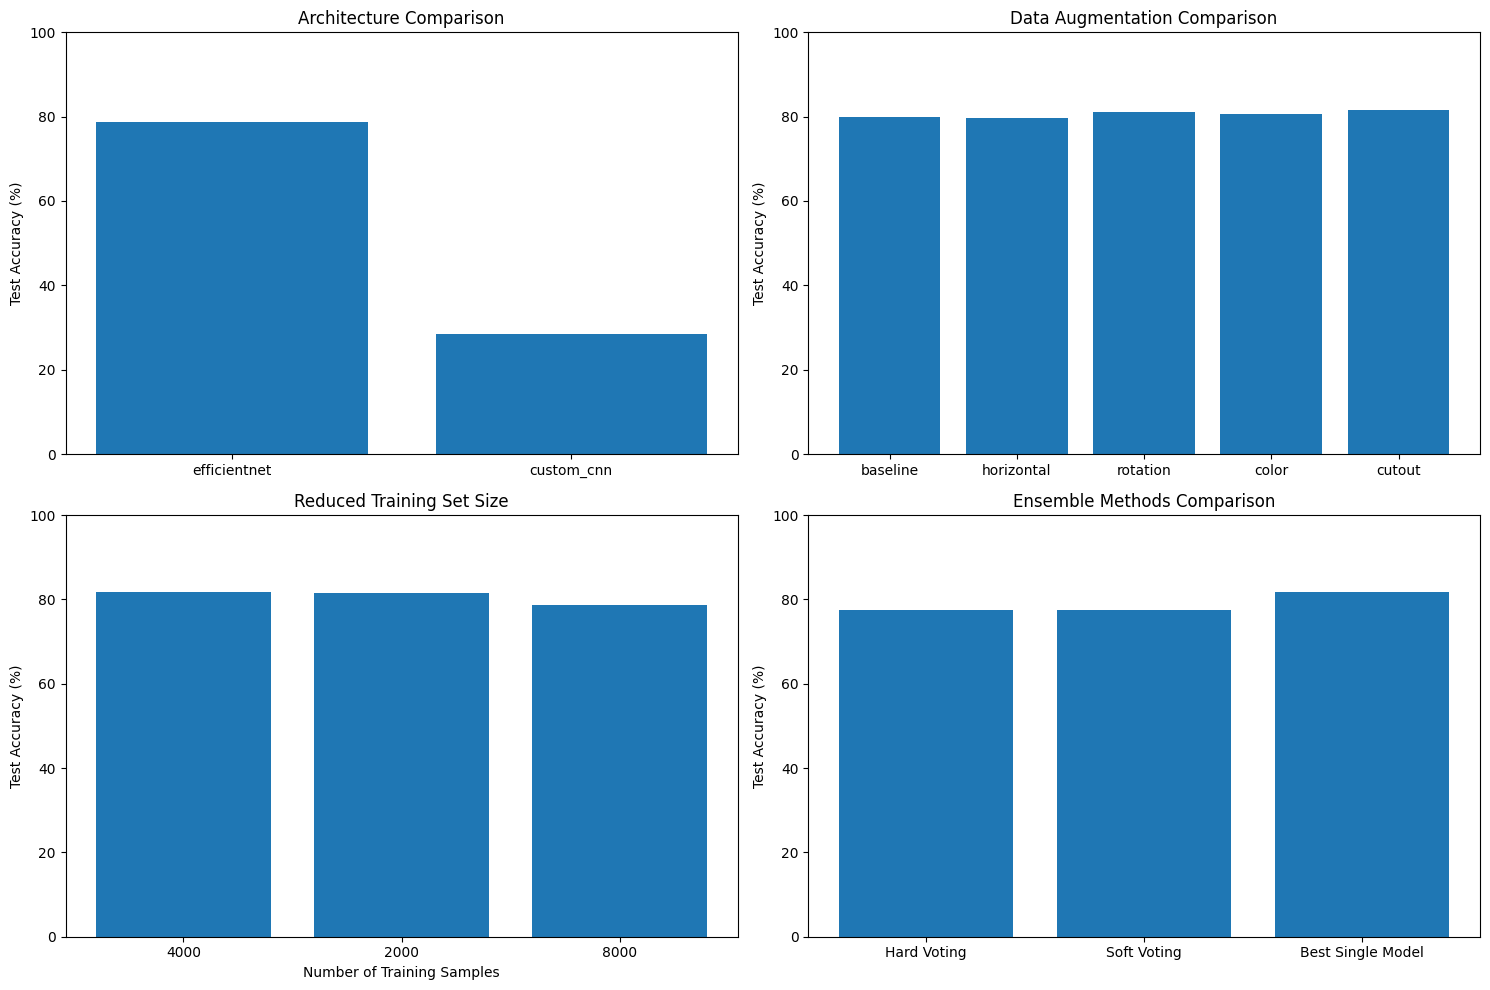

In [28]:
# Create visualizations

# 1. Plot test accuracies
plt.figure(figsize=(15, 10))

# Architecture comparison
plt.subplot(2, 2, 1)
arch_names = list(architecture_results.keys())
arch_accs = [architecture_results[n]['test_accuracy'] for n in arch_names]
plt.bar(arch_names, arch_accs)
plt.title('Architecture Comparison')
plt.ylabel('Test Accuracy (%)')
plt.ylim(0, 100)

# Augmentation comparison
plt.subplot(2, 2, 2)
aug_names = [name.split('_')[1] for name in augmentation_results.keys()]
aug_accs = [augmentation_results[name]['test_accuracy'] for name in augmentation_results.keys()]
plt.bar(aug_names, aug_accs)
plt.title('Data Augmentation Comparison')
plt.ylabel('Test Accuracy (%)')
plt.ylim(0, 100)

# Reduced training set size
plt.subplot(2, 2, 3)
sizes = [name.split('_')[-1] for name in reduction_results.keys()]
size_accs = [reduction_results[name]['test_accuracy'] for name in reduction_results.keys()]
# Add the full dataset result
sizes.append(str(TRAIN_SUBSET_SIZE))
size_accs.append(all_results['Architecture_efficientnet']['test_accuracy'])
plt.bar(sizes, size_accs)
plt.title('Reduced Training Set Size')
plt.xlabel('Number of Training Samples')
plt.ylabel('Test Accuracy (%)')
plt.ylim(0, 100)

# Ensemble comparison
plt.subplot(2, 2, 4)
methods = ['Hard Voting', 'Soft Voting', 'Best Single Model']
accuracies = [
    ensemble_results['hard_voting']['accuracy'],
    ensemble_results['soft_voting']['accuracy'],
    max([results['test_accuracy'] for name, results in all_results.items() if 'test_accuracy' in results])
]
plt.bar(methods, accuracies)
plt.title('Ensemble Methods Comparison')
plt.ylabel('Test Accuracy (%)')
plt.ylim(0, 100)

plt.tight_layout()
plt.savefig('experiment_results_summary.png')
plt.show()

In [29]:
# Save all results to file
import json
import pickle
import numpy as np

# Convert numpy arrays to lists for JSON serialization
def convert_numpy_to_list(obj):
    # Handle NumPy scalars (int64, float32, etc.)
    if isinstance(obj, np.number):
        return obj.item()  # Convert to native Python type
    # Handle NumPy arrays
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    # Handle dictionaries
    elif isinstance(obj, dict):
        return {k: convert_numpy_to_list(v) for k, v in obj.items()}
    # Handle lists and tuples
    elif isinstance(obj, (list, tuple)):
        return [convert_numpy_to_list(item) for item in obj]
    # Return other objects unchanged
    else:
        return obj

# Convert all results
serializable_results = convert_numpy_to_list(all_results)

# Remove model states which can't be serialized easily
for key in serializable_results:
    if isinstance(serializable_results[key], dict) and 'model_state' in serializable_results[key]:
        del serializable_results[key]['model_state']

# Save as JSON for easy viewing
with open('experiment_results.json', 'w') as f:
    try:
        json.dump(serializable_results, f, indent=2)
        print("\nExperiment results saved to 'experiment_results.json'")
    except TypeError as e:
        print(f"Error saving JSON: {e}")
        print("Trying to identify problematic fields...")
        # Try to identify problematic fields
        for key in serializable_results:
            try:
                json.dumps(serializable_results[key])
            except TypeError as e:
                print(f"Problematic field: {key}, Error: {e}")
                # Try to remove or fix this field
                if isinstance(serializable_results[key], dict):
                    for subkey in list(serializable_results[key].keys()):
                        try:
                            json.dumps(serializable_results[key][subkey])
                        except TypeError:
                            print(f"Removing problematic subfield: {key}.{subkey}")
                            serializable_results[key][subkey] = str(serializable_results[key][subkey])
        
        # Try again with the fixed data
        try:
            json.dump(serializable_results, f, indent=2)
            print("Successfully saved JSON after fixing problematic fields")
        except TypeError:
            print("Could not save JSON, falling back to simple format")
            # Save in a simpler format
            with open('experiment_results_simple.txt', 'w') as f:
                for key, value in serializable_results.items():
                    f.write(f"{key}: {str(value)}\n")

print("Summary visualizations saved to 'experiment_results_summary.png'")

# Save full results including model states with pickle
try:
    with open('full_experiment_results.pkl', 'wb') as f:
        pickle.dump(all_results, f)
    print("Full results including model states saved to 'full_experiment_results.pkl'")
except Exception as e:
    print(f"Warning: Could not save full results with model states. Error: {e}")

print("\n" + "="*30 + " EXPERIMENTS COMPLETED " + "="*30)


Experiment results saved to 'experiment_results.json'
Summary visualizations saved to 'experiment_results_summary.png'
Full results including model states saved to 'full_experiment_results.pkl'

============================== EXPERIMENTS COMPLETED ==============================
